<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_05_apply_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T81-558: Applications of Deep Neural Networks
**Module 12: Reinforcement Learning**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 12 Video Material

* Part 12.1: Introduction to the OpenAI Gym [[Video]](https://www.youtube.com/watch?v=_KbUxgyisjM&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_12_01_ai_gym.ipynb)
* Part 12.2: Introduction to Q-Learning [[Video]](https://www.youtube.com/watch?v=A3sYFcJY3lA&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_12_02_qlearningreinforcement.ipynb)
* Part 12.3: Keras Q-Learning in the OpenAI Gym [[Video]](https://www.youtube.com/watch?v=qy1SJmsRhvM&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_12_03_keras_reinforce.ipynb)
* Part 12.4: Atari Games with Keras Neural Networks [[Video]](https://www.youtube.com/watch?v=co0SwPWoZh0&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_12_04_atari.ipynb)
* **Part 12.5: Application of Reinforcement Learning** [[Video]](https://www.youtube.com/watch?v=1jQPP3RfwMI&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_12_05_apply_rl.ipynb)


# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.

In [1]:
try:
    from google.colab import drive
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: using Google CoLab


In [2]:
if COLAB:
  !sudo apt-get install -y xvfb ffmpeg x11-utils
  !pip install -q 'gym==0.10.11'
  !pip install -q 'imageio==2.4.0'
  !pip install -q PILLOW
  !pip install -q 'pyglet==1.3.2'
  !pip install -q pyvirtualdisplay
  !pip install -q tf-agents

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.4).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 59 not upgraded.


# Part 12.5: Application of Reinforcement Learning

Creating an environment is the first step to applying TF-Agent-based reinforcement learning to a problem with your design.  In this part, we will see how to create your environment and apply it to an agent that allows actions to be floating-point values, rather than the discrete actions employed by the Deep Q-Networks (DQN) that we used earlier in this chapter. This new type of agent is called a Deep Deterministic Policy Gradients (DDPG) network. From an application standpoint, the primary difference between DDPG and DQN is that DQN only supports discrete actions, whereas DDPG supports continuous actions; however, there are other essential differences that we will cover later in this chapter.

The environment that I will demonstrate in this chapter simulates paying off a mortgage and saving for retirement.  This simulation allows the agent to allocate their income between several types of account, buying luxury items, and paying off their mortgage. The goal is to maximize net worth.  Because we wish to provide the agent with the ability to distribute their income among several accounts, we provide continuous (floating point) actions that determine this distribution of the agent's salary.

We begin, similarly to previous TF-Agent examples in this chapter, by importing needed packages.




In [3]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import math
import numpy as np

import tensorflow as tf

from tf_agents.agents.ddpg import actor_network
from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.ddpg import ddpg_agent

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.trajectories import policy_step
from tf_agents.utils import common

import gym
from gym import spaces
from gym.utils import seeding
from gym.envs.registration import register
import PIL.ImageDraw
import PIL.Image
from PIL import ImageFont

Note, if you get the following error, restart and rerun the Google CoLab environment.  Sometimes a restart is needed after installing TF-Agents.

```
AttributeError: module 'google.protobuf.descriptor' has no 
    attribute '_internal_create_key'
```

We create a virtual display so that we can view the simulation in a Jupyter notebook.

In [4]:
# Set up a virtual display for rendering OpenAI gym environments.
vdisplay = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

### Create an Environment of your Own

An environment is a simulator that your agent runs in. An environment must have a current state. Some of this state is visible to the agent. However, the environment also hides some aspects of the state from the agent.  Likewise, the agent takes actions that will affect the state of the environment.  There may also be internal actions that occur outside of the control of the agent.  For example, in the finance simulator demonstrated in this section, the agent does not control the investment returns or rate of inflation. Instead, the agent must react to these external actions and state components.

The environment class that you create must contain these elements:

* Be a child class of **gym.Env**
* Implement a **seed** function that sets a seed that governs the simulation's random aspects. For this environment, the seed oversees the random fluctuations in inflation and rates of return.
* Implement a **reset** function that resets the state for a new episode.
* Implement a **render** function that renders one frame of the simulation.  The rendering is only for display and does not affect reinforcement learning.
* Implement a **step** function that performs one step of your simulation.

The class presented below implements a financial planning simulation.  The agent must save for retirement and should attempt to amass the greatest possible net worth.  The simulation includes the following key elements:

* Random starting salary between 40K (USD) and 60K (USD).
* Home loan for a house with a random purchase price that is between 1.5 and 4 times the starting salary.
* Home loan is a standard amortized 30-year loan with a fixed monthly payment.
* Paying higher than the home's monthly payment pays the loan down quicker. Paying below the monthly payment results in late fees and eventually foreclosure.
* Ability to allocate income between luxury purchases, home payments (above or below payment amount), as well as a taxable and tax-advantaged savings account.

The state is composed of the following floating point values:

* **age** - The agent's current age in months (steps) 
* **salary** - The agent's starting salary, increases relative to inflation. 
* **home_value** - The value of the agent's home, increases relative to inflation.
* **home_loan** - How much the agent still owes on their home.
* **req_home_pmt** - The minimum required home payment.
* **acct_tax_adv** - The balance of the tax advantaged retirement account.
* **acct_tax**  - The balance of the taxable retuirement account.

The action space is composed of the following floating-point values (between 0 and 1):

* **home_loan** - The amount to apply to a home loan.
* **savings_tax_adv** - The amount to deposit in a tax-advantaged savings account.
* **savings taxable** - The amount to deposit in a taxable savings account.
* **luxury** - The amount to spend on luxury items/services.

The actions are weights that the program converts to a percentage of the total.  For example, the home loan percentage is the home loan action value divided by all actions (including a home loan).  The following code implements the environment and provides implementation details in the comments.

In [5]:
class SimpleGameOfLifeEnv(gym.Env):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 1
    }

    STATE_ELEMENTS = 7
    STATES = ['age', 'salary', 'home_value', 'home_loan', 'req_home_pmt', 
              'acct_tax_adv', 'acct_tax', "expenses", "actual_home_pmt", 
              "tax_deposit", 
              "tax_adv_deposit", "net_worth"]
    STATE_AGE = 0
    STATE_SALARY = 1
    STATE_HOME_VALUE = 2
    STATE_HOME_LOAN = 3
    STATE_HOME_REQ_PAYMENT = 4
    STATE_SAVE_TAX_ADV = 5
    STATE_SAVE_TAXABLE = 6

    MEG = 1.0e6

    ACTION_ELEMENTS = 4
    ACTION_HOME_LOAN = 0
    ACTION_SAVE_TAX_ADV = 1
    ACTION_SAVE_TAXABLE = 2
    ACTION_LUXURY = 3

    INFLATION = (0.015)/12.0
    INTEREST = (0.05)/12.0
    TAX_RATE = (.142)/12.0
    EXPENSES = 0.6
    INVEST_RETURN = 0.065/12.0
    SALARY_LOW = 40000.0
    SALARY_HIGH = 60000.0
    START_AGE = 18
    RETIRE_AGE = 80

    def __init__(self, goal_velocity=0):
      self.verbose = False
      self.viewer = None

      self.action_space = spaces.Box(
          low=0.0,
          high=1.0,
          shape=(SimpleGameOfLifeEnv.ACTION_ELEMENTS,),
          dtype=np.float32
      )
      self.observation_space = spaces.Box(
          low=0,
          high=2,
          shape=(SimpleGameOfLifeEnv.STATE_ELEMENTS,),
          dtype=np.float32
      )

      self.seed()
      self.reset()

      self.state_log = []

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _calc_net_worth(self):
      home_value = self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE]
      principal = self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN]
      worth = home_value - principal
      worth += self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV]
      worth += self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE]
      return worth

    def _eval_action(self, action, payment):
      # Calculate actions
      act_home_payment = action[SimpleGameOfLifeEnv.ACTION_HOME_LOAN]
      act_tax_adv_pay = action[SimpleGameOfLifeEnv.ACTION_SAVE_TAX_ADV]
      act_taxable = action[SimpleGameOfLifeEnv.ACTION_SAVE_TAXABLE]
      act_luxury = action[SimpleGameOfLifeEnv.ACTION_LUXURY]
      if payment <=0:
        act_home_payment = 0
      total_act = act_home_payment + act_tax_adv_pay + act_taxable + \
            act_luxury + self.expenses

      if total_act <1e-2:
        pct_home_payment = 0
        pct_tax_adv_pay = 0
        pct_taxable = 0
        pct_luxury = 0
      else:
        pct_home_payment = act_home_payment / total_act
        pct_tax_adv_pay = act_tax_adv_pay / total_act
        pct_taxable = act_taxable / total_act
        pct_luxury = act_luxury / total_act

      return pct_home_payment, pct_tax_adv_pay, pct_taxable, pct_luxury

    def step(self, action):
      self.last_action = action
      age = self.state[SimpleGameOfLifeEnv.STATE_AGE]
      salary = self.state[SimpleGameOfLifeEnv.STATE_SALARY]
      home_value = self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE]
      principal = self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN]
      payment = self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT]
      net1 = self._calc_net_worth()
      remaining_salary = salary

      # Calculate actions
      pct_home_payment, pct_tax_adv_pay, pct_taxable, pct_luxury = \
        self._eval_action(action,payment)

      # Expenses
      current_expenses = salary * self.expenses
      remaining_salary -= current_expenses
      if self.verbose:
        print(f"Expenses: {current_expenses}")
        print(f"Remaining Salary: {remaining_salary}")

      # Tax advantaged deposit action
      my_tax_adv_deposit = min(salary * pct_tax_adv_pay, remaining_salary)
      my_tax_adv_deposit = min(my_tax_adv_deposit, \
        self.year_tax_adv_deposit_left) # Govt CAP
      self.year_tax_adv_deposit_left -= my_tax_adv_deposit
      remaining_salary -= my_tax_adv_deposit
      tax_adv_deposit = my_tax_adv_deposit * 1.05 # Company match
      self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV] += \
        int(tax_adv_deposit)

      if self.verbose:
        print(f"IRA Deposit: {tax_adv_deposit}")
        print(f"Remaining Salary: {remaining_salary}")

      # Tax
      remaining_salary -= remaining_salary * SimpleGameOfLifeEnv.TAX_RATE
      if self.verbose:
        print(f"Tax Salary: {remaining_salary}")

      # Home payment
      actual_payment = min(salary * pct_home_payment, remaining_salary)

      if principal>0:
        ipart = principal * SimpleGameOfLifeEnv.INTEREST
        ppart = actual_payment - ipart
        principal = int(principal-ppart)
        if principal<=0:
          principal = 0
          self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT] = 0
        elif actual_payment < payment:
          self.late_count += 1
          if self.late_count>15:
            sell = (home_value-principal)/2
            sell -= 20000
            sell = max(sell,0)
            self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE] += sell
            principal = 0
            home_value = 0
            self.expenses += .3
            self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT] = 0
            if self.verbose:
              print(f"Foreclosure!!")
          else:
            late_fee = payment * 0.1
            principal += late_fee
            if self.verbose:
              print(f"Late Fee: {late_fee}")


        self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN] = principal
        remaining_salary -= actual_payment

      if self.verbose:
        print(f"Home Payment: {actual_payment}")
        print(f"Remaining Salary: {remaining_salary}")

      # Taxable savings
      actual_savings = remaining_salary * pct_taxable
      self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE] += actual_savings
      remaining_salary -= actual_savings

      if self.verbose:
        print(f"Tax Save: {actual_savings}")
        print(f"Remaining Salary (goes to Luxury): {remaining_salary}")

      # Investment income
      return_taxable = self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE] * \
          self.invest_return
      return_tax_adv = self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV] * \
          self.invest_return

      return_taxable *= 1-SimpleGameOfLifeEnv.TAX_RATE
      self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE] += return_taxable
      self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV] += return_tax_adv

      # Yearly events
      if age>0 and age % 12 == 0:
        self.perform_yearly()

      # Monthly events
      self.state[SimpleGameOfLifeEnv.STATE_AGE] += 1
      
      # Time to retire (by age?)
      done = self.state[SimpleGameOfLifeEnv.STATE_AGE] > \
        (SimpleGameOfLifeEnv.RETIRE_AGE*12)

      # Calculate reward 
      net2 = self._calc_net_worth()
      reward = net2 - net1

      # Track progress
      if self.verbose:
        print(f"Networth: {nw}")
        print(f"*** End Step {self.step_num}: State={self.state}, \
          Reward={reward}")
      self.state_log.append(self.state + [current_expenses, actual_payment, 
      actual_savings, my_tax_adv_deposit, net2])
      self.step_num += 1

      # Normalize state and finish up
      norm_state = [x/SimpleGameOfLifeEnv.MEG for x in self.state]
      return norm_state, reward/SimpleGameOfLifeEnv.MEG, done, {}

    def perform_yearly(self):
      salary = self.state[SimpleGameOfLifeEnv.STATE_SALARY]
      home_value = self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE]
      
      self.inflation = SimpleGameOfLifeEnv.INTEREST + \
          self.np_random.normal(loc=0,scale=1e-2)
      self.invest_return = SimpleGameOfLifeEnv.INVEST_RETURN + \
          self.np_random.normal(loc=0,scale=1e-2)

      self.year_tax_adv_deposit_left = 19000
      self.state[SimpleGameOfLifeEnv.STATE_SALARY] = \
        int(salary * (1+self.inflation))

      self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE] \
        = int(home_value * (1+self.inflation))

    def reset(self):
      self.expenses = SimpleGameOfLifeEnv.EXPENSES
      self.late_count = 0
      self.step_num = 0
      self.last_action = [0] * SimpleGameOfLifeEnv.ACTION_ELEMENTS
      self.state = [0] * SimpleGameOfLifeEnv.STATE_ELEMENTS
      self.state_log = []
      salary = float(self.np_random.randint(low=\
                SimpleGameOfLifeEnv.SALARY_LOW,\
                high=SimpleGameOfLifeEnv.SALARY_HIGH))
      house_mult = self.np_random.uniform(low=1.5,high=4)
      value = round(salary*house_mult)
      p = (value*0.9)
      i = SimpleGameOfLifeEnv.INTEREST
      n = 30 * 12
      m = float(int(p *  ( i * (1 + i)**n ) / ( (1 + i)**n - 1)))
      self.state[SimpleGameOfLifeEnv.STATE_AGE] = \
        SimpleGameOfLifeEnv.START_AGE * 12
      self.state[SimpleGameOfLifeEnv.STATE_SALARY] = salary / 12.0
      self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE] = value
      self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN] = p
      self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT] = m
      self.year_tax_adv_deposit_left = 19000
      self.perform_yearly()
      return np.array(self.state)

    def render(self, mode='human'):
        screen_width = 600
        screen_height = 400

        img = PIL.Image.new('RGB', (600, 400))
        d = PIL.ImageDraw.Draw(img)
        font = ImageFont.load_default()
        y = 0
        _, height = d.textsize("W", font)
  
        age = self.state[SimpleGameOfLifeEnv.STATE_AGE]
        salary = self.state[SimpleGameOfLifeEnv.STATE_SALARY]*12
        home_value = self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE]
        home_loan = self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN]
        home_payment = self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT]
        balance_tax_adv = self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV]
        balance_taxable = self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE]
        net_worth = self._calc_net_worth()

        d.text((0, y), f"Age: {age/12}", fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Salary: {salary:,}", fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Home Value: {home_value:,}", \
                fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Home Loan: {home_loan:,}", \
               fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Home Payment: {home_payment:,}", \
               fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Balance Tax Adv: {balance_tax_adv:,}", \
               fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Balance Taxable: {balance_taxable:,}", \
               fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Net Worth: {net_worth:,}", fill=(0, 255, 0))
        y+=height*2

        payment = self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT]
        pct_home_payment, pct_tax_adv_pay, pct_taxable, pct_luxury = \
          self._eval_action(self.last_action,payment)
        d.text((0, y), f"Percent Home Payment: {pct_home_payment}", \
               fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Percent Tax Adv: {pct_tax_adv_pay}", 
               fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Percent Taxable: {pct_taxable}", fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Percent Luxury: {pct_luxury}", fill=(0, 255, 0))

        return np.array(img)

    def close(self):
        pass

You must register the environment class with TF-Agents before your program can use it.

In [6]:
register(
    id='simple-game-of-life-v0',
    entry_point=f'{__name__}:SimpleGameOfLifeEnv',
)

### Testing the Environment

This financial planning environment is complex.  It took me some degree of testing to perfect it.  Even at the current state of this simulator, it is far from a complete financial simulator.  The primary objective of this simulator is to demonstrate creating your own environment for a non-video game project.

I used the following code to help test this simulator.  I ran the simulator with fixed actions and then loaded the state into a Pandas data frame for easy viewing.

In [7]:
env_name = 'simple-game-of-life-v0'
env = gym.make(env_name)

env.reset()
done = False

i = 0
env.verbose = False
while not done:
    i += 1
    #if i>36: break
    # ACTION_HOME_LOAN = 0, ACTION_SAVE_TAX_ADV = 1, ACTION_SAVE_TAXABLE = 2
    # ACTION_LUXURY = 3
    state, reward, done, _ = env.step([1,1,0,0])
    env.render()
    
env.close()
print(env._calc_net_worth())

8012911.816196918


In [8]:
import pandas as pd

df = pd.DataFrame(env.state_log, columns=SimpleGameOfLifeEnv.STATES)
df = df.round(0)
df['age'] = df['age']/12
df['age'] = df['age'].round(2)
for col in df.columns:
  df[col] = df[col].apply(lambda x : "{:,}".format(x))

pd.set_option('display.max_columns', 7)
pd.set_option('display.max_rows', 12)
display(df)

,age,salary,home_value,...,tax_deposit,tax_adv_deposit,net_worth
0,18.08,"4,189","90,751",...,0.0,"1,604.0","10,305.0"
1,18.17,"4,189","90,751",...,0.0,"1,611.0","11,677.0"
2,18.25,"4,189","90,751",...,0.0,"1,611.0","13,050.0"
3,18.33,"4,189","90,751",...,0.0,"1,611.0","14,422.0"
4,18.42,"4,189","90,751",...,0.0,"1,611.0","15,795.0"
...,...,...,...,...,...,...,...
740,79.75,"5,591","121,865",...,0.0,559.0,"7,378,407.0"
741,79.83,"5,591","121,865",...,0.0,559.0,"7,531,492.0"
742,79.92,"5,591","121,865",...,0.0,559.0,"7,687,793.0"
743,80.0,"5,591","121,865",...,0.0,559.0,"7,847,379.0"


1810888.5833333335

## Hyperparameters

I tuned the following hyperparamaters to get a reasonable result from training the agent.  Further optimization would be beneficial.

In [9]:
# How long should training run?
num_iterations = 50000 
# How many initial random steps, before training start, to
# collect initial data.
initial_collect_steps = 1000   
# How many steps should we run each iteration to collect 
# data from.
collect_steps_per_iteration = 50
# How much data should we store for training examples.
replay_buffer_max_length = 100000

batch_size = 64  
#learning_rate = 1e-4 
# How often should the program provide an update.
log_interval = 2500  

# How many episodes should the program use for each evaluation.
num_eval_episodes = 100
# How often should an evaluation occur.
eval_interval = 5000  

## Instanciate the Environment

We are now ready to make use of our environment.  Because we registered the environment with TF-Agents the program can load the environment by its name "simple-game-of-life-v".  You can also try the continuous version of the mountain car environment by switching the name given below.  The continuous mountain car works similar to the discrete mountain car seen previously.  However, the continuous mountain car allows the degree of forward or backward force to be specified.

In [10]:
env_name = 'simple-game-of-life-v0'
#env_name = 'MountainCarContinuous-v0'
env = suite_gym.load(env_name)

We can now have a quick look at the first state rendered. Here we can see the random salary and home values are chosen for an agent.  The learned policy must be able to take into consideration different starting salaries and home values and find an appropriate strategy.

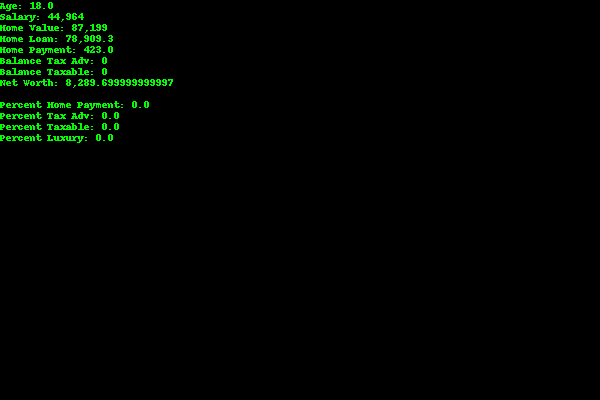

In [11]:
env.reset()
PIL.Image.fromarray(env.render())

Just as before, the program instantiates two environments: one for training and one for evaluation. 

In [12]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

You might be wondering why a DQN does not support continuous actions.  The reason for this limitation is that the DQN algorithm maps each action is an output neuron. Each of these neurons predicts the likely future reward fo taking each action. Generally, the DQN agent will perform the action that has the highest reward. The algorithm knows the future rewards for each particular action.  However, because a continuous number represented in a computer has an effectively infinite number of possible values, it is not possible to calculate a future reward estimate for all of them.

To provide a continuous action space we will use the Deep Deterministic Policy Gradients (DDPG) algorithm. [[Cite:lillicrap2015continuous]](https://arxiv.org/abs/1509.02971) This technique uses two neural networks.  The first neural network, called an actor, acts as the agent and predicts the expected reward for a given value of the action.  The second neural network, called a critic, is trained to predict the accuracy of the actor-network.  Training two neural networks in parallel that operator adversarially to each other is a  popular technique.  Earlier in this course, we saw that Generative Adversarial Networks (GAN) made use of a similar method. Figure 12.DDPG shows the structure of the DDPG network that we will use. 

**Figure 12.DDPG: Actor Critic Model**
![Deep Q-Learning](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/actor-critic.png "Actor Critic Model")

The environment provides the same input ($x(t)$) for each time step to both the actor and critic networks. The temporal difference error ($r(t)$) reports the difference between the estimated reward at any given state or time step and the actual reward. 

The following code creates the actor and critic neural networks.

In [13]:
actor_fc_layers=(400, 300)
critic_obs_fc_layers=(400,)
critic_action_fc_layers=None
critic_joint_fc_layers=(300,)
ou_stddev=0.2
ou_damping=0.15
target_update_tau=0.05
target_update_period=5
dqda_clipping=None
td_errors_loss_fn=tf.compat.v1.losses.huber_loss
gamma=0.995
reward_scale_factor=1.0
gradient_clipping=None

actor_learning_rate=1e-4
critic_learning_rate=1e-3
debug_summaries=False
summarize_grads_and_vars=False

global_step = tf.compat.v1.train.get_or_create_global_step()

actor_net = actor_network.ActorNetwork(
        train_env.time_step_spec().observation,
        train_env.action_spec(),
        fc_layer_params=actor_fc_layers,
    )

critic_net_input_specs = (train_env.time_step_spec().observation,
                          train_env.action_spec())

critic_net = critic_network.CriticNetwork(
    critic_net_input_specs,
    observation_fc_layer_params=critic_obs_fc_layers,
    action_fc_layer_params=critic_action_fc_layers,
    joint_fc_layer_params=critic_joint_fc_layers,
)

tf_agent = ddpg_agent.DdpgAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=actor_learning_rate),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=critic_learning_rate),
    ou_stddev=ou_stddev,
    ou_damping=ou_damping,
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    dqda_clipping=dqda_clipping,
    td_errors_loss_fn=td_errors_loss_fn,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=gradient_clipping,
    debug_summaries=debug_summaries,
    summarize_grads_and_vars=summarize_grads_and_vars,
    train_step_counter=global_step)
tf_agent.initialize()



## Metrics and Evaluation

Just as in previous examples, we will compute the average return over several episodes to evaluate performance.


In [14]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of 
# different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

## Data Collection

Now execute the random policy in the environment for a few steps, recording the data in the replay buffer.

In [15]:
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

collect_data(train_env, random_policy, replay_buffer, steps=100)

# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


## Training the agent

We are now ready to train the agent. This process can take many hours, depending on how many episodes you wish to run through. As training occurs, this code will update on both the loss and average return. As training becomes more successful, the average return should increase. The losses reported reflecting the average loss for individual training batches.

In [16]:
iterator = iter(dataset)

# (Optional) Optimize by wrapping some of the code in a graph using 
# TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, \
                                num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, tf_agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = tf_agent.train(experience).loss

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, \
                                    num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 2500: loss = 0.00048063506255857646
step = 5000: loss = 0.0009628287516534328
step = 5000: Average Return = 5.293339252471924
step = 7500: loss = 0.0018985542701557279
step = 10000: loss = 0.0003614715242292732
step = 10000: Average Return = 8.426756858825684
step = 12500: loss = 0.001215201336890459
step = 15000: loss = 0.000617831654381007
step = 15000: Average Return = 10.426517486572266
step = 17500: loss = 0.0016348579665645957
step = 20000: loss = 0.0035204419400542974
step = 20000: Average Return = 8.884005546569824
step = 22500: loss = 0.5189836025238037
step = 25000: loss = 0.004120268858969212
step = 25000: Average Return = 10.956489562988281
step = 27500: loss = 0.003848570864647627
step = 30000: loss = 0.01014926191419363
step = 30000: Average Return = 8.715755462646484
step = 32500: loss = 0.010892617516219616
step = 35000: loss = 0.0060949139297008514
step = 35000: Average Return = 11.159963607788086
step = 37500: loss = 0.003919485956430435
step = 40000: loss = 0.

## Visualization

The notebook can plot the average return over training iterations. The average return should increase as the program performs more training iterations.

### Plots

Use **matplotlib.pyplot** to chart how the policy improved during training.

One iteration of **Cartpole-v0** consists of 200 time steps. The environment gives a reward of `+1` for each step the pole stays up, so the maximum return for one episode is 200. The charts show the return increasing towards that maximum each time it is evaluated during training. (It may be a little unstable and not increase each time monotonically.)

(4.931626772880554, 50.0)

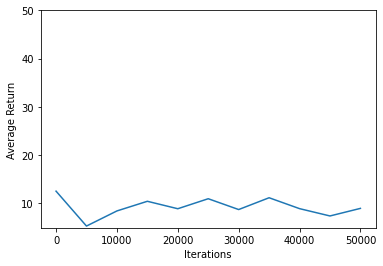

In [17]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=50)

### Videos

We use the following functions to produce video in Jupyter notebook.

In [18]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(tf_agent.policy, "trained-agent")